<center><h3>ĐẠI HỌC QUỐC GIA TP.HCM <br>
TRƯỜNG ĐẠI HỌC CÔNG NGHỆ THÔNG TIN</h3></center>

![halam](logo_uit.png)

# <center>BÁO CÁO MÔN HỌC <br> CHUYÊN ĐỀ NGHIÊN CỨU VÀ ỨNG DỤNG VỀ THỊ GIÁC MÁY TÍNH</h3></center>

# <center>Face Recognition Mini-Challenge </center>

<center><h3> GVHD: PGS.TS. Lê Đình Duy <br> HV: CH1701013 - Hà Lam</h3></center>

<h2> Chương 1. Phương pháp </h2>
<h3>1. Thư viện </h3>

Những thư viện được sử dụng trong bài

In [1]:
from matplotlib.pyplot import imshow
import numpy as np
%matplotlib inline

from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import os
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [18, 12]

- Thư viện sklearn để khai báo các thuật toán classification 
- Thư viện os được sử dụng để khai báo đường dẫn tới ảnh 
- Thư viện PIL để xử lý ảnh
- Thư viện pickle để lưu model sau khi train 
- Thư viện matplotlib để vẽ biểu đồ 
- Thư viện seaborn để vẽ heatmap
- Thư viện face_recognition dùng để nhận diên khuôn mặt 

Chúng ta sử dụng đoạn code sau để ignore những warning không cần thiết 

In [2]:
import warnings
warnings.filterwarnings('ignore')


<h3>2. Dữ liệu </h3>

Dữ liệu huấn luyện và test được lấy từ link sau:
https://drive.google.com/drive/folders/0B6DoUnwvIEdxflIwNmtlT3U0V1pmUjVfZ2E0VXNCNUhtRmcxeE14Z0dJa0lDVmR0V18xNHM 

truy cập lần cuối ngày 28/05/2019

<h3> 3. Thuật toán </h3>

Hàm <b>prepare_training_data</b> để chuẩn bị dữ liệu đầu vào <br>
<b>Input</b>: train_dir: thư mục chứa tất cả ảnh huấn luyện, tên thư mục là tên nhãn vd: thư mục ha_lam chứa tất cả ảnh thuộc về người dùng tên ha_lam <br>
<b>Output</b>: X: dữ liệu huấn luyện đã được vector hoá <br>
y: nhãn của dữ liệu huấn luyện

Các bước xử lý:
    1. Cắt khuôn mặt ra từ ảnh cho trước 
    face_bounding_boxes = face_recognition.face_locations(image)
    2. Encoding dữ liệu khuôn mặt
    face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0]
    3. Nhãn dữ liệu là tên thư mục chứa ảnh người dùng
    y.append(class_dir)

Phân tích dữ liệu:
    1. Mỗi ảnh sau khi encode có kích thước (128,0)
       print((face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0]).shape)
    2. Ở đây thuật toán đọc được 21 nhãn tượng trưng cho 21 user
        print(len(set(y_train)))
        Có 2 nhãn thuật toán không nhận diện được khuôn mặt: TANPV, ThuyLTN
           len(face_bounding_boxes) == 0
        Có 4 nhãn thư mục rỗng (không chứa ảnh): HONG NHUNG, PHUCTN, PHUONGTD, THUONGNC, TUANPV
    3. Dữ liệu training gồm tổng cộng 42 ảnh 

In [3]:
def prepare_training_data(train_dir):
  X = []
  y = []
  for class_dir in os.listdir(train_dir):
    if not os.path.isdir(os.path.join(train_dir, class_dir)):
        continue
    for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
      image = face_recognition.load_image_file(img_path)
      face_bounding_boxes = face_recognition.face_locations(image)
      if len(face_bounding_boxes) == 1:      
        X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
        y.append(class_dir)
  return X, y

Hàm <b>prepare_test_data</b> dùng để chuẩn bị test data <br>
<b>Input</b>: đường dẫn tới ảnh để kiểm nghiệm <br>
<b>Output<b>: dữ liệu test đã được vector hoá <br>

In [4]:
def prepare_test_data(X_img_path):
  X_img = face_recognition.load_image_file(X_img_path)
  X_face_locations = face_recognition.face_locations(X_img)
  if len(X_face_locations) == 0:
      return []
  faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

  return faces_encodings

Hàm <b>train_model</b> để huấn luyện mô hình <br>
<b>Input</b>: X_train, y_train lần lượt là dữ liệu huấn luyện và nhãn <br>
<b>Output</b>: đường dẫn chứa các model đã được huấn luyện <br>

Các bước xử lý:
    1. Chúng ta sử dụng 6 mô hình classification để đánh giá thuật toán 
    LinearDiscriminantAnalysis, KNeighborsClassifier
    DecisionTreeClassifier, LogisticRegression, GaussianNB, SVC
    2. Train mô hình
    clf.fit(X_train, y_train)
    3. Lưu mô hình sau khi train 
     pickle.dump(clf, f)

In [5]:
def train_model(X_train, y_train):
  num_neighbors = 2 
  distance_threshold = 0.6

  models = []
  models.append(('LDA', LinearDiscriminantAnalysis())) # tot nhat
  models.append(("LR",LogisticRegression(solver='newton-cg')))
  models.append(("NB",GaussianNB()))
  models.append(("KNN",KNeighborsClassifier(n_neighbors=num_neighbors, algorithm='ball_tree', weights='distance'))) # # tot nhat nhat 
  models.append(("DT",DecisionTreeClassifier(criterion = "entropy")))
  models.append(("SVM",SVC(kernel='sigmoid',gamma='scale',shrinking=False,probability=True)))

  models_path = []
  for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    model_name = name + '.clf'
    models_path.append(model_name)
    with open(model_name, 'wb') as f:
      pickle.dump(clf, f)
  
  return models_path

Hàm <b>evalute_classification_algorithms</b> dùng để đánh giá kết quả của các mô hình với ảnh đang xét <br>
<b>Input</b>: X_test: dữ liệu kiểm thử <br>
y_test: nhãn của dữ liệu kiểm thử (phần này được tác giả làm bằng tay đối với từng ảnh dùng kiểm thử) <br>
models_path: đường dẫn chứa các model đã được huấn luyện <br>
is_full: để hiển thị full kết quả


In [6]:
def evalute_classification_algorithms(X_test, models_path, y_test, is_full=False):
    for model_path in models_path:
        with open(model_path, 'rb') as f:
            clf = pickle.load(f)
            y_pred = clf.predict(X_test)
            print("{0} accuracy score: {1:.2f}".format(model_path, metrics.accuracy_score(y_test, y_pred)))
            if (is_full):
                print("{0} Classification Results:\n{1}".format(model_path, metrics.classification_report(y_test, y_pred)))
                print(f"Heatmap của {model_path}")
                cm = metrics.confusion_matrix(y_test, y_pred)
                sns.heatmap(cm)
                plt.show()
            print("="*50)


Ta tiến hành huấn luyện 

In [7]:
X_train, y_train = prepare_training_data("dataset/train")
models_path = train_model(X_train, y_train)

Sau bước này ta có được các mô hình đã huấn luyện với dữ liệu ta cung cấp

Tiến hành kiểm tra 6 model vừa train với ảnh 26_3_3_test.png trong test data set 

y_test: nhãn cho ảnh 26_3_3_test.png được làm thủ công bởi tác giả 

In [8]:
y_test = ['HANTQ','MINHHA','unknown','HOAISD','unknown','TAIHPT','unknown','HOBV','VULQ','unknown','QUANVM','TULG','unknown','DUYETLV','unknown','TIENBDT']

Đường dẫn chứa các model đã được huấn luyện

In [9]:
models_path = ['LDA.clf', 'LR.clf', 'NB.clf', 'KNN.clf', 'DT.clf', 'SVM.clf']

In [10]:
test_image_path = 'dataset/test/26_3_3_test.png'
X_test = prepare_test_data(test_image_path)
evalute_classification_algorithms(X_test,models_path,y_test)

LDA.clf accuracy score: 0.44
LR.clf accuracy score: 0.12
NB.clf accuracy score: 0.12
KNN.clf accuracy score: 0.62
DT.clf accuracy score: 0.31
SVM.clf accuracy score: 0.12


Để hiện thị thêm kết quả, ta có thể truyền thêm biến: is_full = True <br>
Ở chế độ này, có hiển thị thêm heat map thể hiện độ tương quan giữa y_pred (kết quả dự đoán) và y_test (kết quả thực tế)

LDA.clf accuracy score: 0.44
LDA.clf Classification Results:
              precision    recall  f1-score   support

       ANHLT       0.00      0.00      0.00         0
     DUYETLV       0.50      1.00      0.67         1
       DUYNN       0.00      0.00      0.00         0
       HANTQ       1.00      1.00      1.00         1
      HOAISD       1.00      1.00      1.00         1
        HOBV       0.00      0.00      0.00         1
      MINHHA       0.33      1.00      0.50         1
      QUANVM       0.25      1.00      0.40         1
      TAIHPT       1.00      1.00      1.00         1
     TIENBDT       0.00      0.00      0.00         1
        TULG       1.00      1.00      1.00         1
        VULQ       0.00      0.00      0.00         1
     unknown       0.00      0.00      0.00         6

   micro avg       0.44      0.44      0.44        16
   macro avg       0.39      0.54      0.43        16
weighted avg       0.32      0.44      0.35        16

Heatmap của LDA.cl

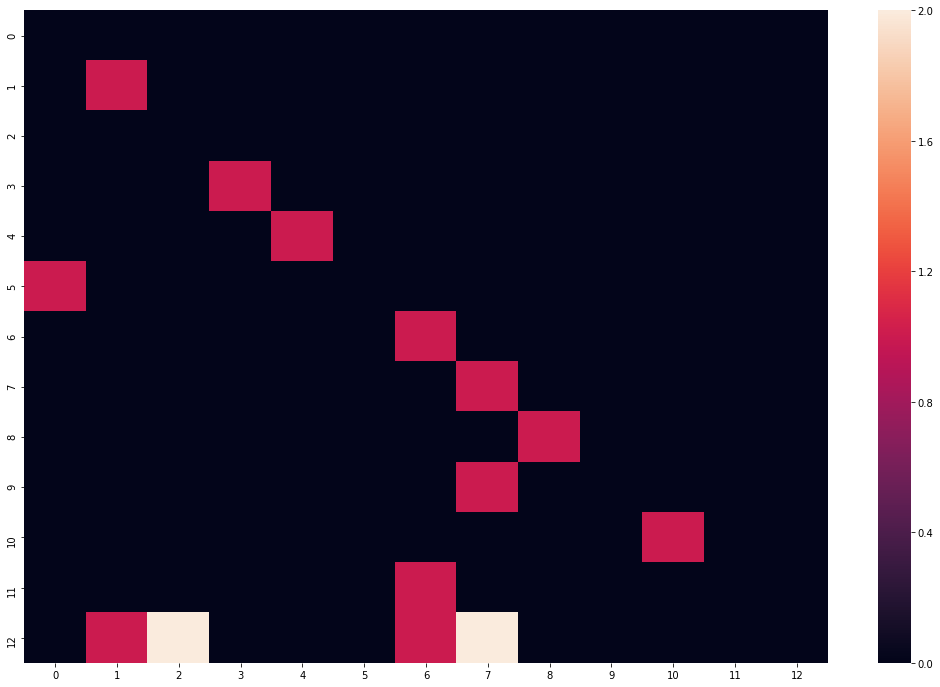

LR.clf accuracy score: 0.12
LR.clf Classification Results:
              precision    recall  f1-score   support

     DUYETLV       0.12      1.00      0.22         1
       HANTQ       0.00      0.00      0.00         1
      HOAISD       0.00      0.00      0.00         1
        HOBV       0.12      1.00      0.22         1
      MINHHA       0.00      0.00      0.00         1
      QUANVM       0.00      0.00      0.00         1
      TAIHPT       0.00      0.00      0.00         1
     TIENBDT       0.00      0.00      0.00         1
        TULG       0.00      0.00      0.00         1
        VULQ       0.00      0.00      0.00         1
     unknown       0.00      0.00      0.00         6

   micro avg       0.12      0.12      0.12        16
   macro avg       0.02      0.18      0.04        16
weighted avg       0.02      0.12      0.03        16

Heatmap của LR.clf


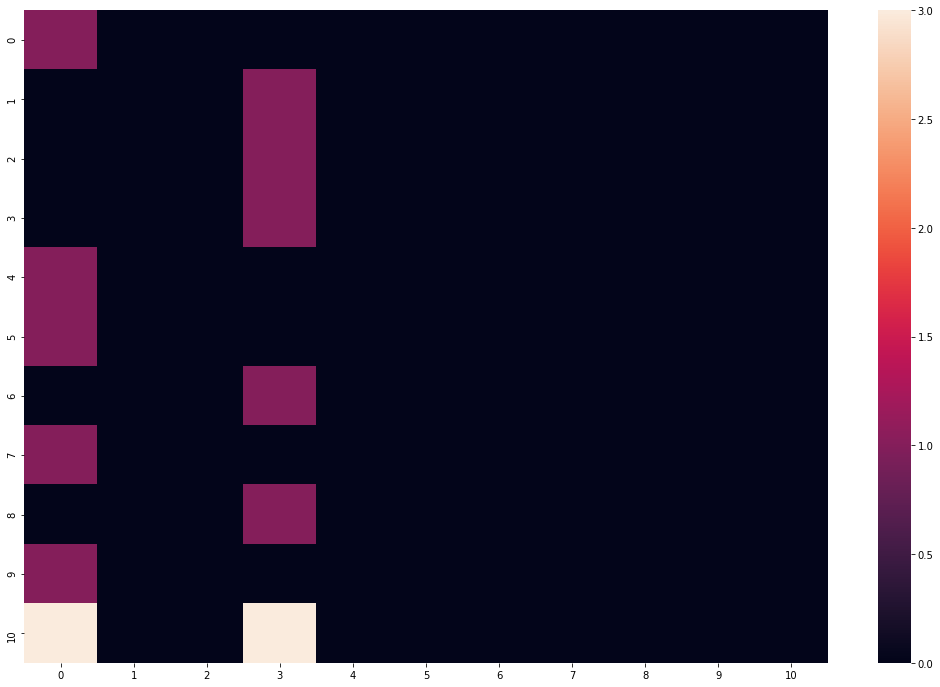

NB.clf accuracy score: 0.12
NB.clf Classification Results:
              precision    recall  f1-score   support

     DUYETLV       0.00      0.00      0.00         1
       HANTQ       0.00      0.00      0.00         1
      HOAISD       0.00      0.00      0.00         1
        HOBV       0.14      1.00      0.25         1
      MINHHA       0.11      1.00      0.20         1
      QUANVM       0.00      0.00      0.00         1
      TAIHPT       0.00      0.00      0.00         1
     TIENBDT       0.00      0.00      0.00         1
        TULG       0.00      0.00      0.00         1
        VULQ       0.00      0.00      0.00         1
     unknown       0.00      0.00      0.00         6

   micro avg       0.12      0.12      0.12        16
   macro avg       0.02      0.18      0.04        16
weighted avg       0.02      0.12      0.03        16

Heatmap của NB.clf


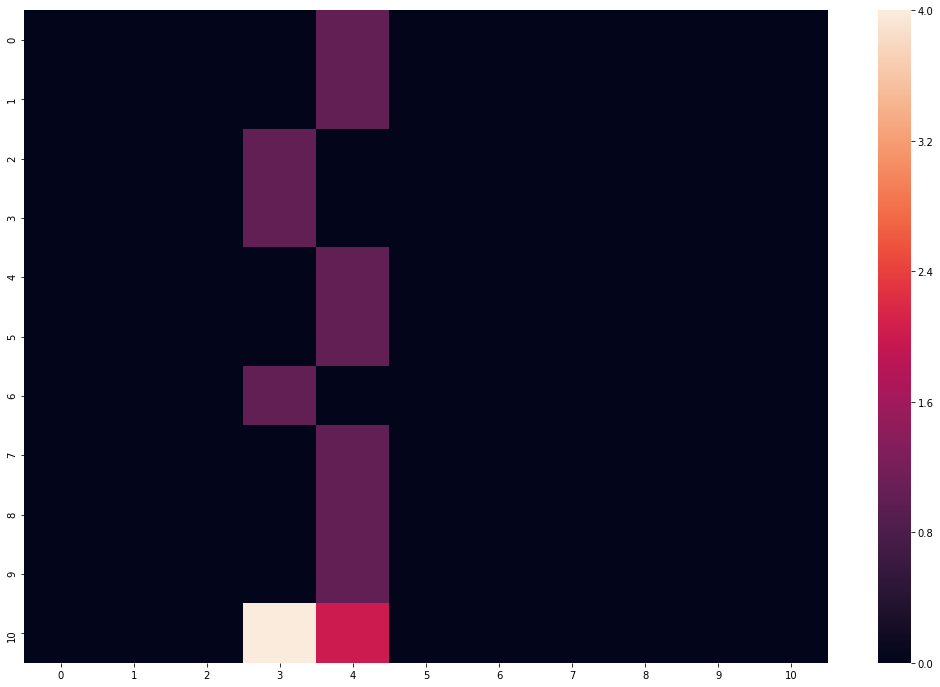

KNN.clf accuracy score: 0.62
KNN.clf Classification Results:
              precision    recall  f1-score   support

     CUONGNT       0.00      0.00      0.00         0
     DUYETLV       1.00      1.00      1.00         1
       HANTQ       0.50      1.00      0.67         1
      HOAISD       1.00      1.00      1.00         1
        HOBV       1.00      1.00      1.00         1
      MINHHA       1.00      1.00      1.00         1
      QUANVM       0.33      1.00      0.50         1
      TAIHPT       1.00      1.00      1.00         1
     TIENBDT       1.00      1.00      1.00         1
        TULG       1.00      1.00      1.00         1
        VULQ       0.33      1.00      0.50         1
     unknown       0.00      0.00      0.00         6

   micro avg       0.62      0.62      0.62        16
   macro avg       0.68      0.83      0.72        16
weighted avg       0.51      0.62      0.54        16

Heatmap của KNN.clf


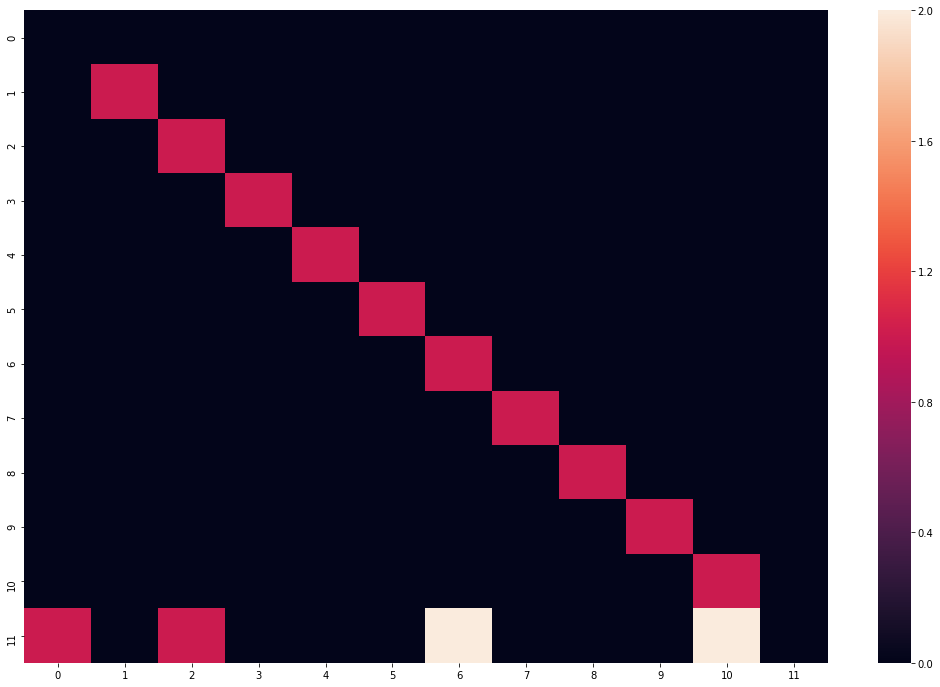

DT.clf accuracy score: 0.31
DT.clf Classification Results:
              precision    recall  f1-score   support

     CUONGNT       0.00      0.00      0.00         0
     DUYETLV       0.00      0.00      0.00         1
       HANTQ       1.00      1.00      1.00         1
      HOAISD       0.00      0.00      0.00         1
        HOBV       1.00      1.00      1.00         1
       LOCTH       0.00      0.00      0.00         0
      MINHHA       0.00      0.00      0.00         1
      NHANTH       0.00      0.00      0.00         0
      QUANVM       0.50      1.00      0.67         1
      TAIHPT       1.00      1.00      1.00         1
       TANTD       0.00      0.00      0.00         0
     THAODNT       0.00      0.00      0.00         0
     TIENBDT       0.00      0.00      0.00         1
        TULG       0.00      0.00      0.00         1
        VULQ       1.00      1.00      1.00         1
     unknown       0.00      0.00      0.00         6

   micro avg       0.

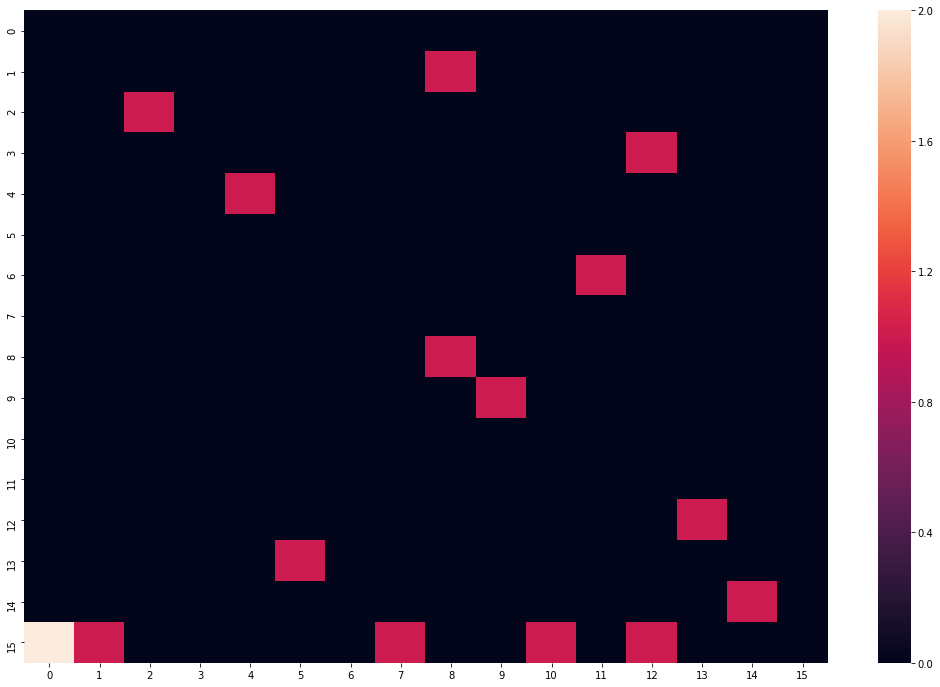

SVM.clf accuracy score: 0.12
SVM.clf Classification Results:
              precision    recall  f1-score   support

     DUYETLV       0.11      1.00      0.20         1
       HANTQ       0.00      0.00      0.00         1
      HOAISD       0.00      0.00      0.00         1
        HOBV       0.14      1.00      0.25         1
      MINHHA       0.00      0.00      0.00         1
      QUANVM       0.00      0.00      0.00         1
      TAIHPT       0.00      0.00      0.00         1
     TIENBDT       0.00      0.00      0.00         1
        TULG       0.00      0.00      0.00         1
        VULQ       0.00      0.00      0.00         1
     unknown       0.00      0.00      0.00         6

   micro avg       0.12      0.12      0.12        16
   macro avg       0.02      0.18      0.04        16
weighted avg       0.02      0.12      0.03        16

Heatmap của SVM.clf


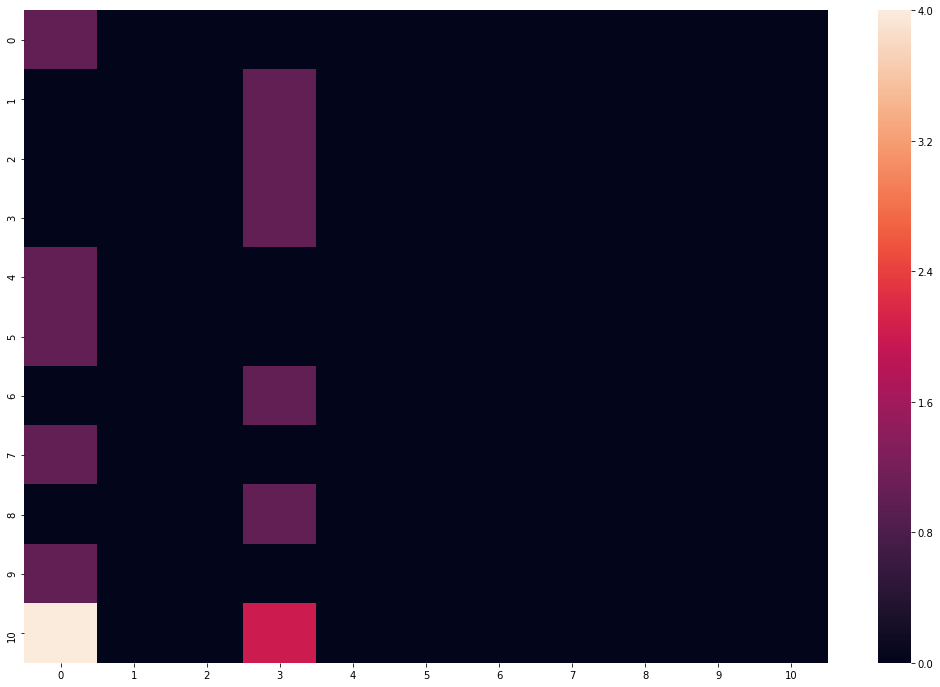

In [11]:
plt.rcParams['figure.figsize'] = [18, 12]
evalute_classification_algorithms(X_test,models_path,y_test,True)

Thuật toán cho kết quả cao nhất là <b>KNeighborsClassifier</b>

Sau đây là bảng so sánh kết quả của 6 thuật toán và 4 bức ảnh dùng để test <br>
LinearDiscriminantAnalysis, KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, GaussianNB, SVC <br>
Lưu ý: ở đây ta tính độ chính xác dựa trên tổng số khuôn mặt mà thuật toán detect được 

| Ảnh | Tên thuật toán | Độ chính xác
| --- | --- | --- |
| 26_3_3_test.png | KNeighborsClassifier | 0.62 |
| 26_3_3_test.png | LinearDiscriminantAnalysis | 0.44 |
| 26_3_3_test.png | LogisticRegression | 0.12 |
| 26_3_3_test.png | GaussianNB | 0.12 |
| 26_3_3_test.png | DecisionTreeClassifier | 0.19 |
| 26_3_3_test.png | SVC | 0.12 |
|  |
| 26_3_4_test.png | KNeighborsClassifier | 0.71 |
| 26_3_4_test.png | LinearDiscriminantAnalysis | 0.43 |
| 26_3_4_test.png | LogisticRegression | 0.14 |
| 26_3_4_test.png | GaussianNB | 0.29 |
| 26_3_4_test.png | DecisionTreeClassifier | 0.29 |
| 26_3_4_test.png | SVC | 0.14 |
||
| 26_3_1_test.png | KNeighborsClassifier | 0.0 |
| 26_3_1_test.png | LinearDiscriminantAnalysis | 0.0 |
| 26_3_1_test.png | LogisticRegression | 0.0 |
| 26_3_1_test.png | GaussianNB | 0.0 |
| 26_3_1_test.png | DecisionTreeClassifier | 0.0 |
| 26_3_1_test.png | SVC | 0.0 |
||
| 26_3_2_test.png | KNeighborsClassifier | 0.0 |
| 26_3_2_test.png | LinearDiscriminantAnalysis | 0.0 |
| 26_3_2_test.png | LogisticRegression | 0.0 |
| 26_3_2_test.png | GaussianNB | 0.0 |
| 26_3_2_test.png | DecisionTreeClassifier | 0.0 |
| 26_3_2_test.png | SVC | 0.0 |

Chú thích: dưới đây là nhãn của 4 ảnh tác giả làm bằng tay <br>
Nhãn unknown: đại diện cho ảnh của user không có trong tập training data set 
    - Ảnh 26_3_3_test.png
        y_test = ['HANTQ','MINHHA','unknown','HOAISD','unknown','TAIHPT','unknown','HOBV','VULQ','unknown','QUANVM','TULG','unknown','DUYETLV','unknown','TIENBDT']
        Số khuôn mặt thuật toán nhận diện được: 16
        Số khuôn mặt thực tế (đếm bởi tách giả): 22
    - Ảnh 26_3_4_test.png
        y_test = ['unknown','unknown','HOBV','MINHHA','VULQ','HOAISD','TULG']
        Số khuôn mặt thuật toán nhận diện được: 7
        Số khuôn mặt thực tế (đếm bởi tách giả): 12
    - Ảnh 26_3_1_test.png
        y_test = ['unknown','unknown','unknown','unknown','unknown','unknown']
        Số khuôn mặt thuật toán nhận diện được: 6
        Số khuôn mặt thực tế (đếm bởi tách giả): 15
    - Ảnh 26_3_2_test.png
        y_test = ['unknown','unknown','unknown','unknown','unknown','unknown','unknown','unknown','unknown']
        Số khuôn mặt thuật toán nhận diện được: 9
        Số khuôn mặt thực tế (đếm bởi tách giả): 11
Nhận xét: trong data set có 2 ảnh chứa người dùng có trong tập huấn luyện <br>
    2 ảnh còn lại hoàn toàn xa lạ, không chứa bất kỳ người dùng nào trong tập huấn luyện

Nhận xét kết quả: <br>
    - Trong 6 thuật toán: thuật toán KNeighborsClassifier chạy tốt nhất trên những ảnh có xuất hiện ở training data 
    - Cả 6 thuật toán không nhận diện tốt trong trường hợp toàn người lạ.
    - Số lượng khuôn mặt nhận diện được của thuật toán không đạt được 100%. Do có một số người dùng cúi mặt xuống, chỉ chụp được nửa khuôn mặt, bị người phía trước che.
    - Thuật toán nhận diện tốt khuôn mặt hướng về phía camera

<h3> 4. Hiển thị một số kết quả </h3>


Ta dùng thuật toán KNeighborsClassifier <br>
Ta khai báo thêm các hàm sau để thuận tiện cho việc hiển thi hình ảnh

Hàm <b>predictict</b> dùng để predict kết quả <br>
<b>Input</b>: 
 X_img_path: đường dẫn đến ảnh kiểm tra <br>
 model_path: đường dẫn chứa các model đã được huấn luyện <br>
 distance_threshold: ngưỡng. Vd: threshold = 0.6. Nếu < 0.6 thì gán nhãn là unknown và ngược lại <br>
 n_neighbors: Số lượng 'hàng xóm' của thuật toán KNeighborsClassifier 
<br>
<b>Output</b>: Toạ độ vị trí của các khuôn mặt

In [12]:
def predict(X_img_path, model_path, distance_threshold, n_neighbors):
  with open(model_path, 'rb') as f: 
    knn_clf = pickle.load(f)
  
  X_img = face_recognition.load_image_file(X_img_path)
  X_face_locations = face_recognition.face_locations(X_img)

  if len(X_face_locations) == 0:
    return []
  
  faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

  closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors)
  are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

  return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]

Hàm <b>show_prediction_labels_on_image</b> dùng để hiển thị kết quả predict <br>
<b>Input </b>: 
    img_path: đường dẫn đến ảnh kiểm tra <br>
    predictions: Kết quả dự đoán và vị trí của các khuôn mặt

In [13]:
def show_prediction_labels_on_image(img_path, predictions):
    pil_image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(pil_image)

    for name, (top, right, bottom, left) in predictions:
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))
        name = name.encode("UTF-8")
        text_width, text_height = draw.textsize(name)
        draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
        draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))
    del draw

    imshow(np.asarray(pil_image))
    plt.show()


Chúng ta tiến hành chạy thuật toán

26_3_1_test.png
- Tìm thấy VULQ tại (2833, 993)
- Tìm thấy TIENBDT tại (2540, 892)
- Tìm thấy LOCTH tại (855, 1027)
- Tìm thấy MYNH tại (2337, 928)
- Tìm thấy NHANTH tại (191, 1158)
- Tìm thấy NHANTH tại (1118, 976)


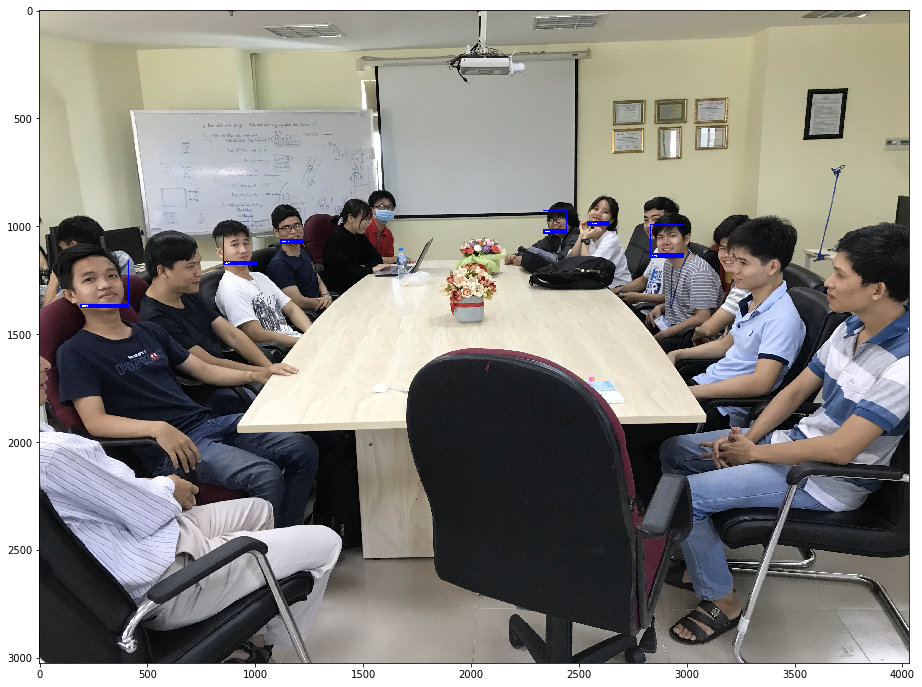

26_3_4_test.png
- Tìm thấy VULQ tại (241, 935)
- Tìm thấy VULQ tại (1668, 1525)
- Tìm thấy HOBV tại (1430, 1257)
- Tìm thấy MINHHA tại (1009, 1034)
- Tìm thấy VULQ tại (2595, 1109)
- Tìm thấy HOAISD tại (2638, 1420)
- Tìm thấy TULG tại (1777, 910)


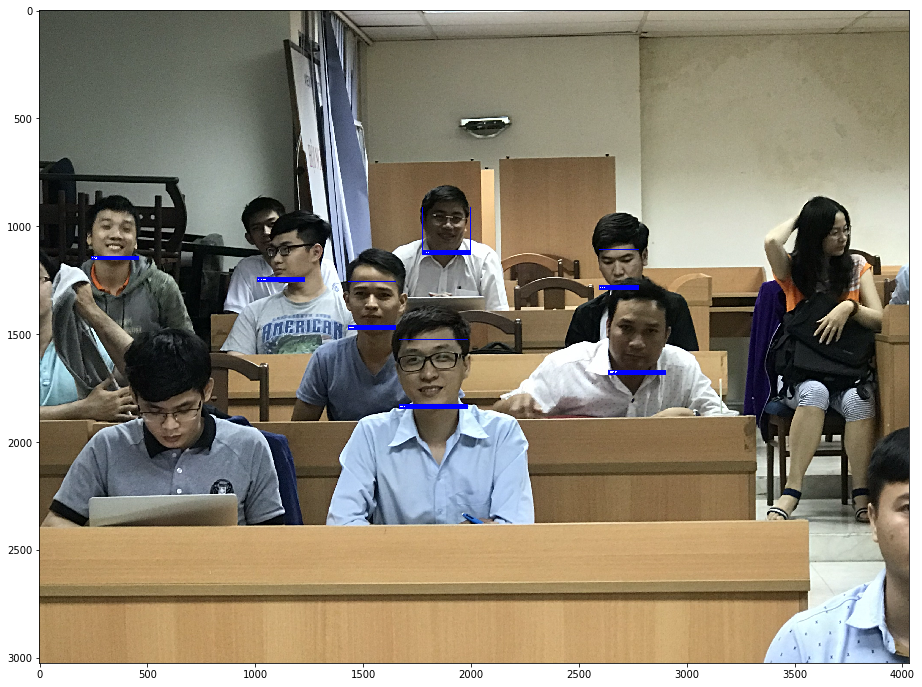

26_3_2_test.png
- Tìm thấy TULG tại (1453, 1346)
- Tìm thấy TULG tại (1589, 1231)
- Tìm thấy TULG tại (1687, 1386)
- Tìm thấy TIENBDT tại (2045, 1343)
- Tìm thấy TULG tại (1907, 1274)
- Tìm thấy MINHHA tại (1330, 1151)
- Tìm thấy MINHHA tại (2285, 1460)
- Tìm thấy QUANVM tại (159, 1316)
- Tìm thấy MYNH tại (3312, 1653)


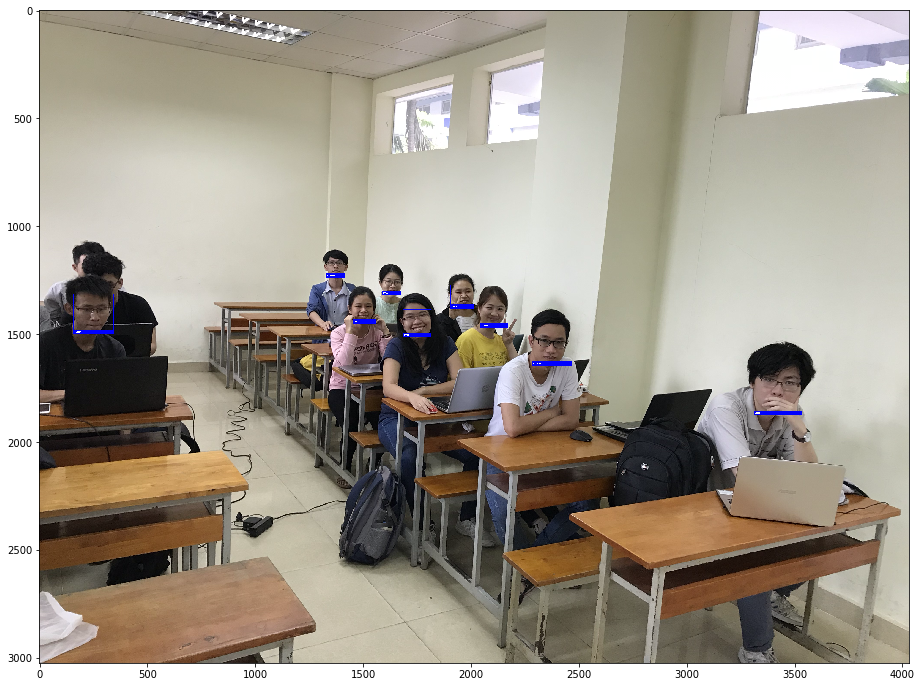

26_3_3_test.png
- Tìm thấy HANTQ tại (170, 1632)
- Tìm thấy MINHHA tại (1472, 913)
- Tìm thấy VULQ tại (956, 999)
- Tìm thấy HOAISD tại (2317, 1113)
- Tìm thấy QUANVM tại (3464, 956)
- Tìm thấy TAIHPT tại (3202, 1628)
- Tìm thấy QUANVM tại (1810, 1212)
- Tìm thấy HOBV tại (1646, 1044)
- Tìm thấy VULQ tại (2389, 956)
- Tìm thấy HANTQ tại (3722, 1042)
- Tìm thấy QUANVM tại (683, 1010)
- Tìm thấy TULG tại (1887, 827)
- Tìm thấy VULQ tại (3806, 892)
- Tìm thấy DUYETLV tại (98, 1027)
- Tìm thấy CUONGNT tại (3352, 904)
- Tìm thấy TIENBDT tại (2934, 844)


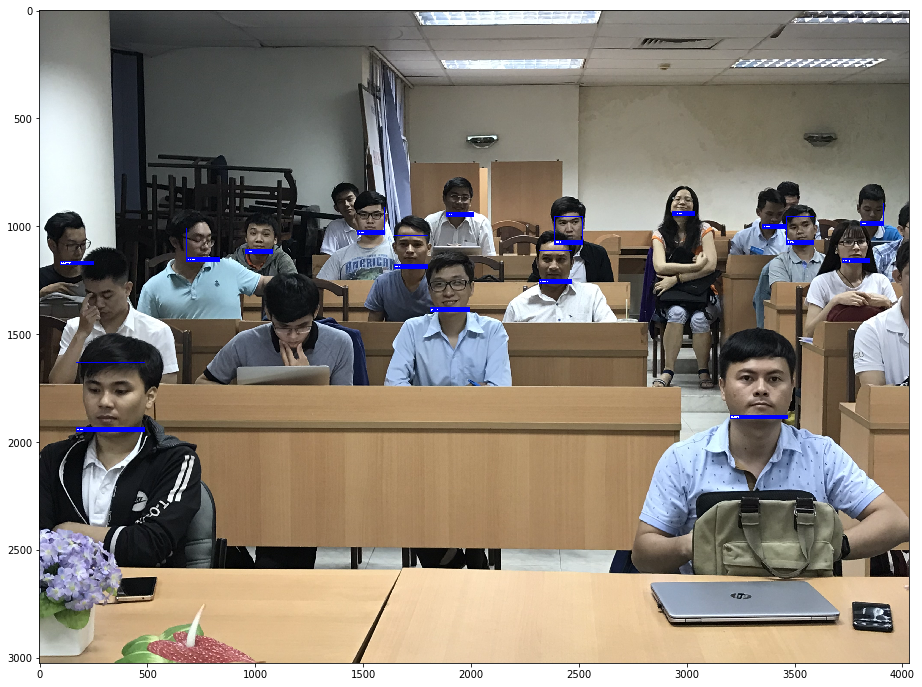

In [14]:
plt.rcParams['figure.figsize'] = [18, 12]
for class_dir in os.listdir('dataset/test'):
    print(class_dir)
    image_path = 'dataset/test/' + class_dir
    predictions = predict(image_path, "KNN.clf", 0.8, 2)
    for name, (top, right, bottom, left) in predictions:
        print("- Tìm thấy {} tại ({}, {})".format(name, left, top))
    show_prediction_labels_on_image(image_path, predictions)


Hiểu đúng được nội dung bài toán, kỹ thuật, tại sao lại chọn, tại sao thấp/cao
Giải thích đc sự lựa chọn 

<h2> Chương 2. Phân tích thuật toán </h2>


<h3>1. Giới thiệu </h3>

Kỹ thuật gồm 4 bước:
1. Tìm được khuôn mặt từ bức ảnh cho trước (face detection)
2. Rút trích các đặc trưng từ khuôn mặt tìm được (encoding) 
3. So sánh với khuôn mặt đã có trong kho dữ liệu
4. Đưa ra dự đoán

<h3>2. Face detection </h3>

Convert bức ảnh sang trắng đen và dùng các mũi tên biểu hiện lại bức ảnh theo hướng độ sáng. <br>
Mũi tên hướng theo chiều tối <br>
Thư viện face_recognition dùng thuật toán HOG để phát hiện khuôn mặt <br>

<h3>3. Projecting face </h3>

Để giải quyết vấn đề một người có thể có nhiều góc chụp khác nhau (nghiêng, lệch, trực diện so với camera). Dẫn tới máy tính biểu diễn khác nhau. <br>
Thư viện face_recognition dùng face landmark estimation. Để cố định mắt, mũi, miệng ... ở vị trí cố định trong mọi bức ảnh <br>
Thuật toán sử 68 landmarks được học thông qua machine learning

![halam](face_land_marks.png)

Hình 1: Landmarks từ Machine Learning is Fun! Part 4: Modern Face Recognition with Deep Learning, Adam Geitgey

<h3>4. Encoding face </h3>

Thuật toán sử dụng Deep Convolutional Neural Network để rút trích 128 features của bức ảnh. <br>
Đó cũng chính là số chiều chúng ta nhận được khi gọi face_recognition.face_encodings(image)

<h3>5. Prediction </h3>

Chúng ta có thể sử dụng 1 trong 6 thuật toán classification ở trên, để dự đoán tag của một 
bức ảnh bất kỳ

<h3>6. Lý do lựa chọn </h3>
    
1. Thư viện face_recognition cung cấp đầy đủ api về yêu cầu của bài toán Face Recognition Mini-Challenge
Khiến việc code dễ dàng hơn cho những người không có kiến thức nền về Thị giác máy tính
2. Việc không có phần cứng phù hợp để train mô hình thúc đẩy tác giả sử dụng những mô hình đã được train sẵn
3. Thư viện giúp cho tác giả nhanh chóng có kết quả và những kiến thức cơ bản để từ đó đi tiếp lên 
chuyên sâu

<b>Thuật toán chưa đạt được 100% </b>
 - Do chất lượng ảnh huấn luyện rất thấp (chiếm 90% tác giả đã kiểm nghiệm với tập dữ liệu người nổi tiếng cho kết quả rất tốt)
 - Có nhiều khuôn mặt bị che khuất, cắt camera không ghi nhận được mắt, mũi, miệng (landmarks)
nên thất bại trong việc detect khuôn mặt
 - Thuật toán được huấn luyện với dữ liệu ảnh chủ yếu người châu Âu. Nên apply qua bài toán cho 
người châu Á sẽ bị sai sót. [Dẫn chứng từ tác giả thư viện](https://github.com/ageitgey/face_recognition/issues/612)

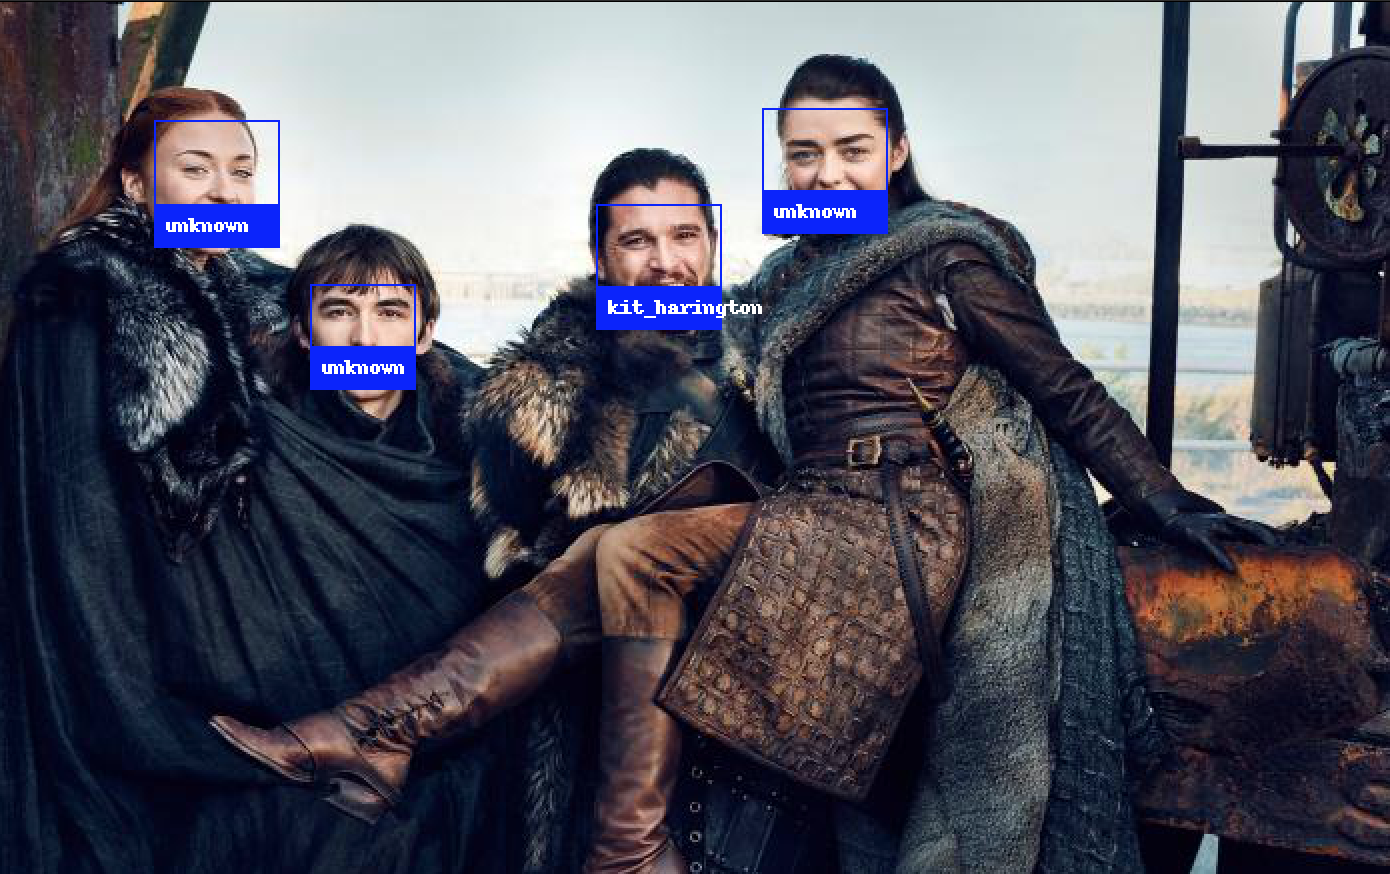

Hình 2: Detect nhân vật game of throne. Với bộ ảnh tốt cho chất lượng rất tốt

<h2>Chương 3. Link tài liệu tham khảo </h2>

[1] https://github.com/ageitgey/face_recognition truy cập lần cuối ngày 28/05/2019 <br>
[2] https://www.kaggle.com/serkanpeldek/face-recognition-on-olivetti-dataset truy cập lần cuối ngày 28/05/2019 <br>
[3] https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78 truy cập lần cuối ngày 28/05/2019 <br>
[4] google class môn học 'Chuyên đề nghiên cứu và ứng dụng về Thị giác máy tính' https://classroom.google.com/c/MjcwOTI2MTMyOTFa truy cập lần cuối ngày 28/05/2019 